# XStoryCloze evaluation

In [1]:
import pandas as pd

def get_dfs(model_names):
    acc_df = pd.DataFrame()
    ppl_cor_df = pd.DataFrame()
    ppl_inc_df = pd.DataFrame()

    for model_name in model_names:
        name = model_name.split("/")[-1]
        metrics_df = pd.read_csv(f"../results/xstory_cloze_{name}_metrics.tsv", delimiter="\t")
        acc_df["lang"] = metrics_df["lang"]
        ppl_cor_df["lang"] = metrics_df["lang"]
        ppl_inc_df["lang"] = metrics_df["lang"]
        acc_df[name] = metrics_df["acc"]
        ppl_cor_df[name] = metrics_df["ppl_cor"]
        ppl_inc_df[name] = metrics_df["ppl_inc"]

    return acc_df, ppl_cor_df, ppl_inc_df

import matplotlib.pyplot as plt

def plot_df(df, title):
    df.plot.bar()
    plt.title(title)
    plt.xticks(list(range(12)), df["lang"], rotation='vertical')
    plt.show()

## mGPT

In [14]:
metrics_df = pd.read_csv(f"../results/xstory_cloze_mGPT_metrics.tsv", delimiter="\t")

In [16]:
metrics_df

,lang,acc,ppl_cor,ppl_inc
0,en,63.2,22.11,23.34
1,ru,61.3,13.46,13.95
2,zh,57.0,18.05,18.53
3,es,58.8,18.31,18.96
4,ar,53.3,25.94,26.39
5,hi,56.5,4.51,4.57
6,id,58.8,20.74,21.51
7,te,58.2,3.62,3.68
8,sw,57.8,13.06,13.44
9,eu,55.9,17.82,18.22


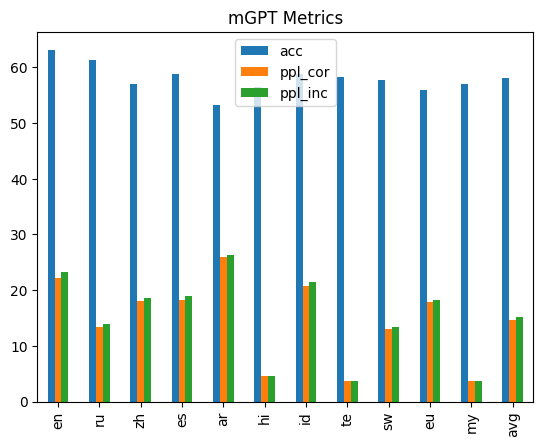

In [18]:
plot_df(metrics_df, "mGPT Metrics")

## XGLM

In [5]:
xglm_model_names=[
    "facebook/xglm-564M",
    "facebook/xglm-1.7B",
    "facebook/xglm-2.9B",
    "facebook/xglm-4.5B",
    "facebook/xglm-7.5B",
]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(xglm_model_names)

In [6]:
acc_df

,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,61.3,66.6,69.6,72.1,73.7
1,ru,59.5,62.8,67.2,66.8,69.0
2,zh,56.3,60.2,64.1,64.4,65.9
3,es,56.5,60.6,64.6,66.4,66.7
4,ar,53.9,55.6,57.7,57.7,58.5
5,hi,54.2,56.8,59.4,57.1,59.5
6,id,56.8,61.5,65.5,65.6,68.0
7,te,56.9,58.4,59.4,58.7,60.6
8,sw,56.4,60.8,60.8,60.1,63.3
9,eu,55.1,57.5,58.4,55.3,61.7


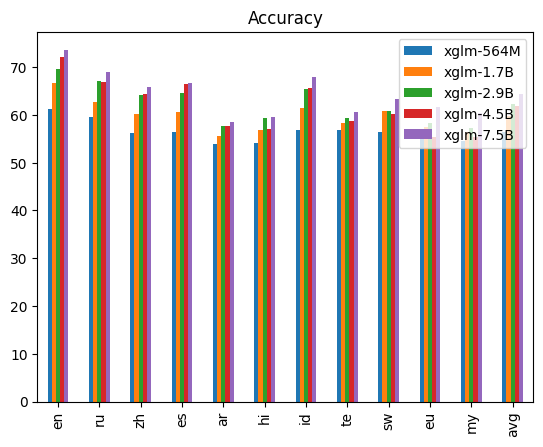

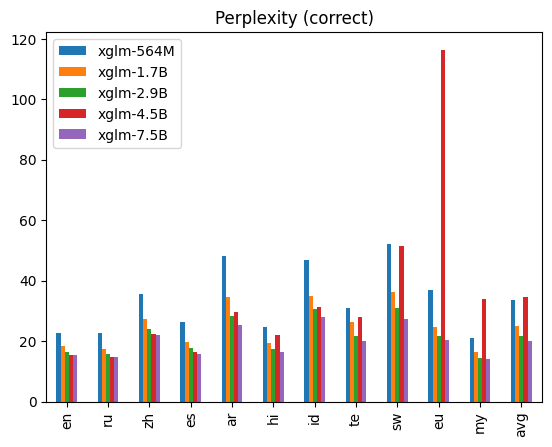

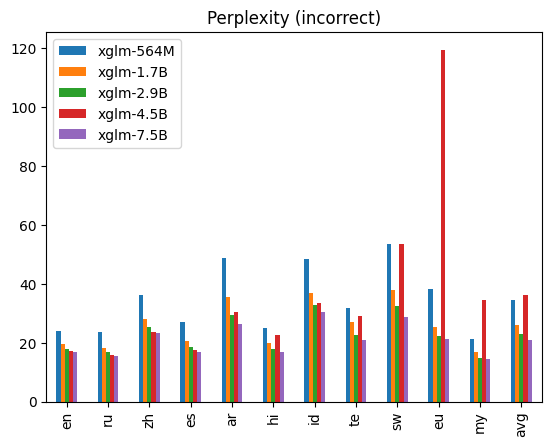

In [7]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")

## BLOOM

In [8]:
bloom_model_names=[
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloom_model_names)

In [9]:
acc_df

,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,64.1,67.4,70.0,72.1,74.9
1,ru,55.3,54.3,56.7,57.7,59.2
2,zh,58.8,63.3,65.0,67.3,69.4
3,es,58.7,61.3,64.3,67.0,70.1
4,ar,52.7,56.5,56.0,59.6,62.5
5,hi,54.3,56.7,57.8,58.6,62.7
6,id,56.9,61.8,62.9,66.8,69.4
7,te,55.2,55.3,56.0,58.5,57.5
8,sw,52.7,53.7,57.7,58.0,59.2
9,eu,53.8,53.8,55.7,57.2,59.0


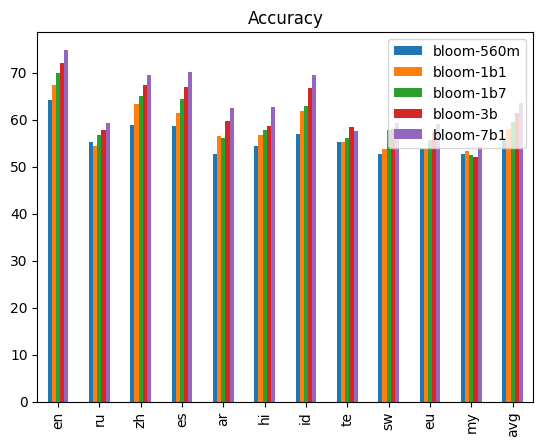

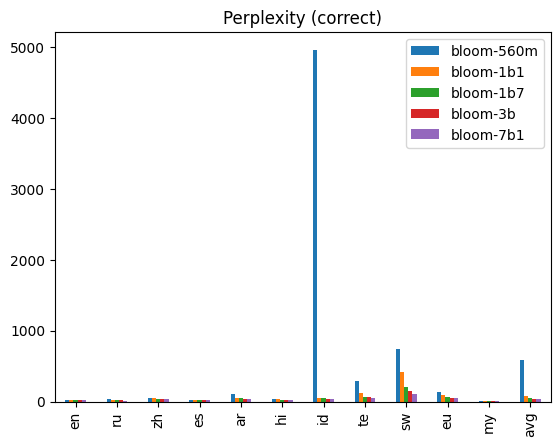

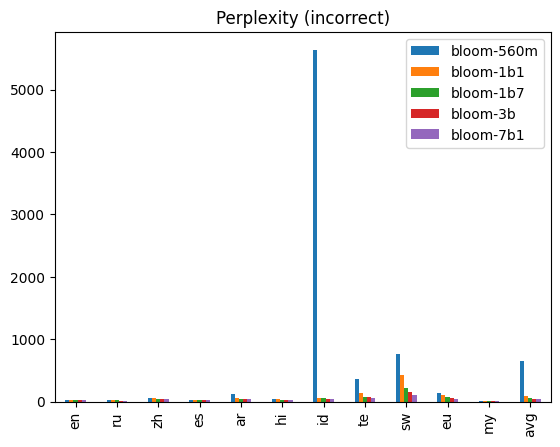

In [10]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")

## BLOOMZ

In [11]:
bloomz_model_names=[
    "bigscience/bloomz-560m",
    "bigscience/bloomz-1b1",
    "bigscience/bloomz-1b7",
    "bigscience/bloomz-3b",
    "bigscience/bloomz-7b1",
    "bigscience/bloomz-7b1-mt",
    "bigscience/bloomz-7b1-p3",
]

acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloomz_model_names)

In [12]:
acc_df

,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,66.0,68.8,72.4,74.4,78.0,78.4,78.1
1,ru,54.9,53.5,55.1,56.2,56.8,57.0,59.1
2,zh,62.3,64.3,63.1,62.9,66.8,67.6,73.2
3,es,60.0,62.3,60.4,58.3,68.0,67.5,69.2
4,ar,55.2,58.1,56.3,56.3,60.8,62.1,66.5
5,hi,54.6,57.4,55.1,55.3,59.6,57.8,65.8
6,id,50.6,62.9,57.9,58.2,61.5,61.2,67.5
7,te,52.5,55.0,52.0,52.8,55.3,54.5,59.2
8,sw,53.4,53.5,52.4,53.8,54.9,56.2,59.2
9,eu,47.1,52.0,47.2,45.9,52.9,51.1,59.1


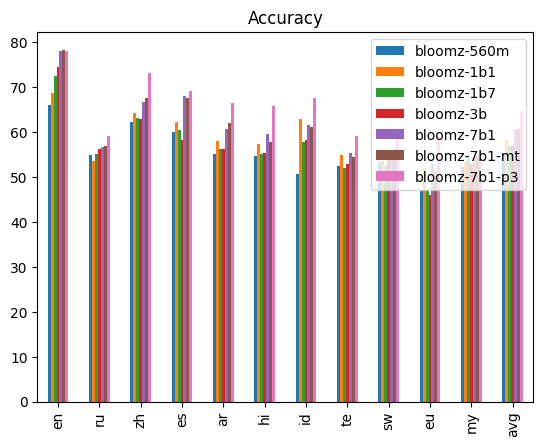

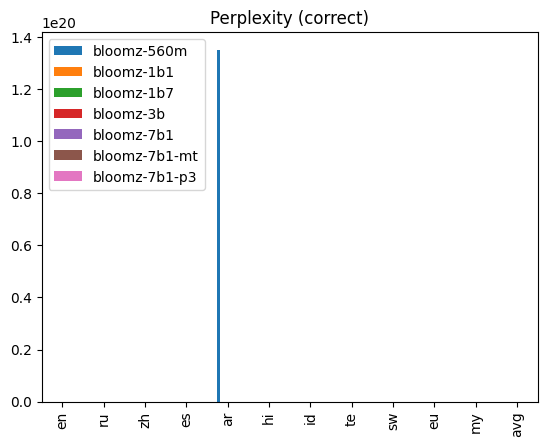

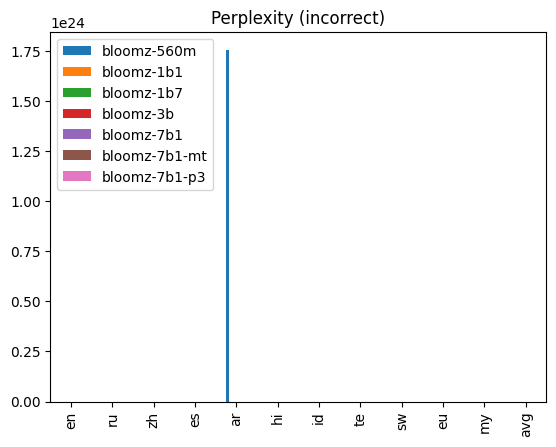

In [13]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")